In [1]:
import ot
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import scanpy as sc
from scipy.sparse import coo_matrix

/home/wuxinchao/.conda/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
prot_data_path = "/home/wuxinchao/data/st_cite_data/B01825A4_protein_filter.csv"
rna_data_path = "/home/wuxinchao/data/st_cite_data/B01825A4_rna_raw.csv"

In [4]:
prot_data = pd.read_csv(prot_data_path)
rna_data = pd.read_csv(rna_data_path)

In [8]:
gene_map = {
    "CD11c": "Itgax",
    "CD27" : "Cd27",
    "CD8a" : "Cd8a",
    "CD68" : "Cd68",
    "2" : "Thy1",
    "CD3" : "Cd3g",
    "CD44" : "Cd44",
    "CD5" : "Cd5",
    "CD4" : "Cd4",
    "CD29" : "Itgb1"
}

In [9]:
# prot_data.columns = prot_data.columns.str.split("_").str[-1]
prot_data.columns = prot_data.columns.str.split("_").str[-1]
# rename the columns of the prot_data based on the gene_map
prot_data.rename(columns=gene_map, inplace=True)

# using the data in prot_data replace the columns in rna_data
rna_data.index = rna_data["Unnamed: 0"]
rna_data.drop("Unnamed: 0", axis=1, inplace=True)
prot_data.index = prot_data["Unnamed: 0"]
prot_data.drop("Unnamed: 0", axis=1, inplace=True)

# rna_coords
rna_coords = np.asarray(rna_data.index.str.split("_", expand=True))
rna_coordination = np.asarray([[int(coord[0]), int(coord[1])] for coord in rna_coords])

# prot_coords
prot_coords = np.asarray(prot_data.index.str.split("_", expand=True))
prot_coordination = np.asarray([[int(coord[0]), int(coord[1])] for coord in prot_coords])

In [5]:
a = [.5, .5]
b = [.4, .6]
M = [[0, 1], [1, 0]]
ot.sinkhorn2(a, b, M, 1)

0.2805354607075431

In [6]:
ot.emd2(a, b, M)

0.09999999999999998

The Sinkhorn-Knopp algorithm is implemented in `ot.sinkhorn` and `ot.sinkhorn2` that return respectively the OT matrix and the value of the linear term.  
Using a regularization parameter that is not too small the default Sinkhorn solver should be enough. If you need to use a small regularization to get sharper OT matrices, you should use stablied solver that will avoid numerical errors. `ot.bregman.sinkhorn_epsilon_scaling` could be very slow and not even converge to a reasonable OT matrix in a finite time.  
The greedy version of the Sinkhorn `ot.bregman.greenkhorn` can also lead to a speedup and the screening version of the Sinkhorn `ot.bregman.screenkhorn` aim a providing a fast approximation of Sinkhorn problem.  
For use of GPU, use `ot.bregman.sinkhorn_log`

In [9]:
# (rna_data.align(prot_data, axis=0, join="inner"))
# rna_data
# prot_data.shape # (5974, 10)
fuzed_data = rna_data.join(prot_data, how="outer", lsuffix="_rna", rsuffix="_prot")

In [10]:
# convert the Nan to 0
fuzed_data = fuzed_data.fillna(0)
# for the columns that end with "_prot" and "_rna", keep the _prot feature and drop the _rna feature
fuzed_data = fuzed_data.loc[:,~fuzed_data.columns.str.endswith("_rna")]
# change the name of the columns, remove the "_prot" suffix
fuzed_data.columns = fuzed_data.columns.str.replace("_prot", "")

In [11]:
fuzed_data_path = "/home/wuxinchao/data/st_cite_data/B01825A4_fuzed_data.csv"
fuzed_data.to_csv(fuzed_data_path)

In [12]:
# fuzed_data.loc[:,fuzed_data.columns.str.endswith("_rna")]
# load the data into the scanpy, and the data is the fuzed_data
# And I want to transform the index of the fuzed_data to a new meta data in anndata
# The index of the fuzed_data is the location of the cell in the spatial slide, x_y is the location of the spot
# I want to transform the x_y to the meta data of the anndata object in the form of "x", "y"
fuzed_data_path = "/home/wuxinchao/data/st_cite_data/B01825A4_fuzed_data.csv"
adata = sc.read_csv(fuzed_data_path, first_column_names=True)

In [13]:
coordinates = fuzed_data.index.str.split("_", expand=True)
# convert the coordinates to the int type
coordinates = np.asarray(coordinates)
coordination = np.zeros((0, 2))
for coord in coordinates:
    x = int(coord[0])
    y = int(coord[1])
    coordination = np.vstack((coordination, [x, y]))

In [14]:
# download the data from the url and test the read coordinates function
# import urllib.request
# url_coord = "https://www.pnas.org/highwire/filestream/887973/field_highwire_adjunct_files/15/pnas.1912459116.sd15.xlsx"
# filename_coord = "./data/st_cite_data/pnas.1912459116.sd15.xlsx"
# urllib.request.urlretrieve(url_coord, filename_coord)

In [15]:
adata.obsm["spatial"] = coordination

In [16]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e6)
sc.pp.log1p(adata)
sc.pp.pca(adata, n_comps=15)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="clusters", resolution=0.5)

In [17]:
adata

AnnData object with n_obs × n_vars = 9181 × 25818
    obs: 'n_counts', 'clusters'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

/home/wuxinchao/.conda/envs/torch/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


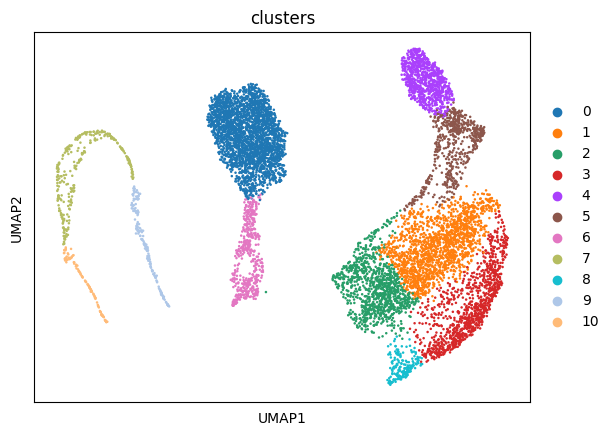

/home/wuxinchao/.conda/envs/torch/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


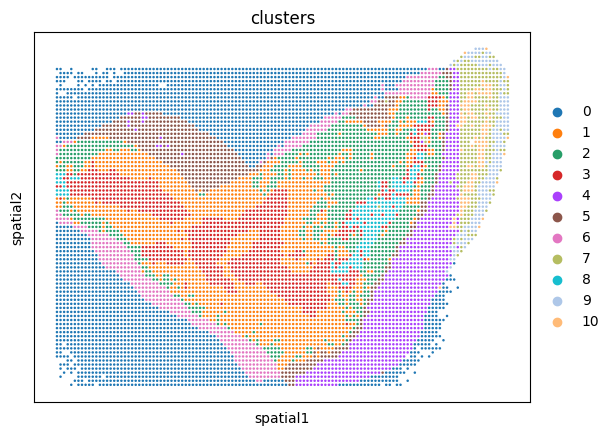

In [18]:
sc.pl.umap(adata, color="clusters")
sc.pl.embedding(adata, basis="spatial", color="clusters")

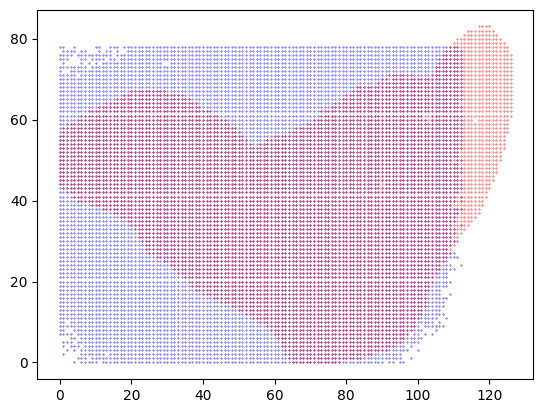

In [20]:
# rna_data.index.str.split("_", expand=True)
plt.scatter(rna_coordination[:, 0], rna_coordination[:, 1], c="b", marker="o", s = 0.1)
# plt.scatter(prot_coordination[:, 0], prot_coordination.max(axis=0)[1]-prot_coordination[:, 1], c="r", marker="o", s = 0.1)
plt.scatter(prot_coordination[:, 0], prot_coordination[:, 1], c="r", marker="o", s = 0.1)

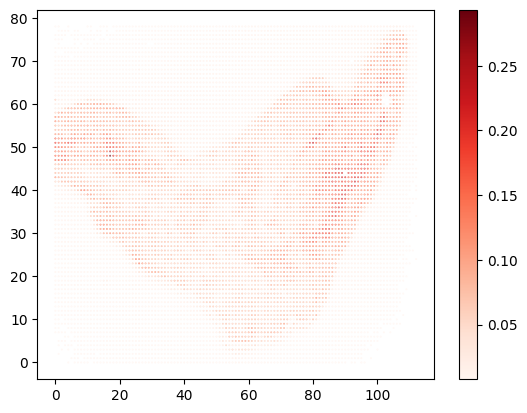

In [21]:
# plot the rna expression, colored with the rna mean expression
plt.scatter(rna_coordination[:,0], rna_coordination[:,1], marker="o", s = 0.1, c=rna_data.mean(axis=1), cmap="Reds")
plt.colorbar()

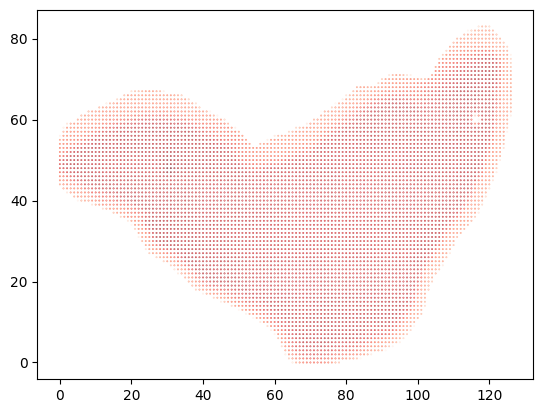

In [22]:
plt.scatter(prot_coordination[:,0], prot_coordination[:,1], marker="o", s = 0.1, c=np.log(prot_data.mean(axis=1)), cmap="Reds")

In [23]:
import matplotlib.pylab as pl
import torch
import matplotlib.animation as animation

XX, YY = np.meshgrid(np.arange(prot_coordination.shape[0]), np.arange(prot_coordination.shape[0]))

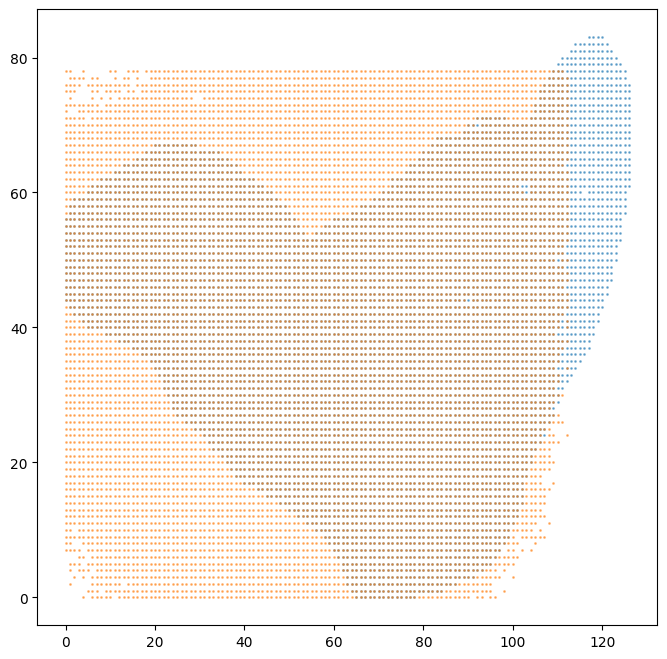

In [24]:
# prot_data.mean(axis=1)
# x1 = np.stack((XX[I1 == 0], YY[I1 == 0]), axis=1) * 1.0

pl.figure(1, (8, 8))
pl.scatter(prot_coordination[:, 0], prot_coordination[:, 1], alpha=0.5, s=1)
pl.scatter(rna_coordination[:, 0], rna_coordination[:, 1], alpha=0.5, s=1)

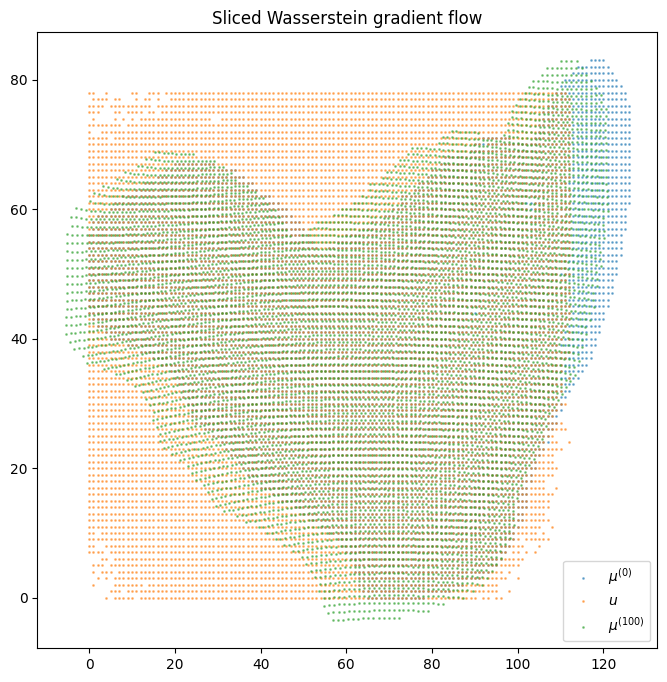

In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# use pyTorch for our data
x1 = torch.tensor(prot_coordination, dtype=torch.float32).to(device).requires_grad_(True)
x2 = torch.tensor(rna_coordination, dtype=torch.float32).to(device)

lr = 1e3
nb_iter_max = 100
x_all = np.zeros((nb_iter_max, x1.shape[0], 2))
loss_iter = []

# generator for random permutations
gen = torch.Generator()
gen.manual_seed(42)

for i in range(nb_iter_max):
    loss = ot.sliced_wasserstein_distance(x1, x2, n_projections=50, seed=gen)
    loss_iter.append(loss.clone().detach().cpu().numpy())
    loss.backward()

    # performs a step of projected gradient descent
    with torch.no_grad():
        grad = x1.grad
        x1 -= grad * lr / (1 + i / 5e1) # step
        x1.grad.zero_()
        x_all[i, :, :] = x1.clone().detach().cpu().numpy()

xb = x1.clone().detach().cpu().numpy()

pl.figure(2, (8, 8))
pl.scatter(prot_coordination[:, 0], prot_coordination[:,1], alpha=0.5, s=1, label="$\mu^{(0)}$")
pl.scatter(x2[:, 0], x2[:, 1], alpha=0.5, s=1, label="$u$")
pl.scatter(xb[:, 0], xb[:, 1], alpha=0.5, s=1, label="$\mu^{(100)}$")
pl.title("Sliced Wasserstein gradient flow")
pl.legend()
ax = pl.axis()

In [13]:
rna_df = pd.DataFrame(rna_data.mean(axis=1) * 1000, index=rna_data.index)
rna_df["X"] = rna_coordination[:, 0]
rna_df["Y"] = rna_coordination[:, 1]

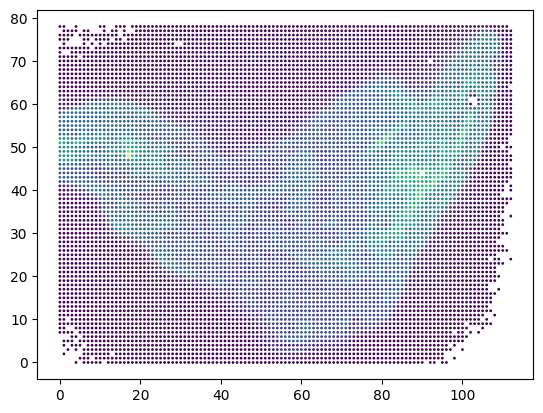

In [29]:
plt.scatter(rna_df["X"], rna_df["Y"], c=rna_df[0], marker="o", s = 1)

In [14]:
prot_df = pd.DataFrame(prot_data.mean(axis=1), index=prot_data.index)
prot_df["X"] = prot_coordination[:, 0]
prot_df["Y"] = prot_coordination[:, 1]

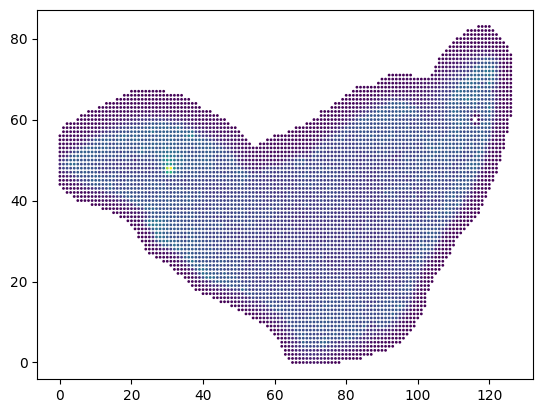

In [31]:
plt.scatter(prot_df["X"], prot_df["Y"], c=prot_df[0], marker="o", s = 1)

In [29]:
# implement the OT mapping of the rna and protein expression data
# use the rna data as the source and the protein data as the target

# the fisrt step is to fill the missing values in the protein data and rna data with zeros
# define the meshgrid of the matrix coordination of protein data
rna_mtx, prot_mtx = np.meshgrid(np.arange(prot_df["X"].max()+1), np.arange(prot_df["Y"].max()+1))
rna_mtx = np.zeros_like(rna_mtx).T
prot_mtx = np.zeros_like(prot_mtx).T

# fill the grid with the protein data value
for i in range(prot_df.shape[0]):
    spot = prot_df.iloc[i]
    x = int(spot["X"])
    y = int(spot["Y"])
    prot_mtx[x, y] = spot[0]

# fill the grid with the rna data value
for i in range(rna_df.shape[0]):
    spot = rna_df.iloc[i]
    x = int(spot["X"])
    y = int(spot["Y"])
    rna_mtx[x, y] = spot[0]

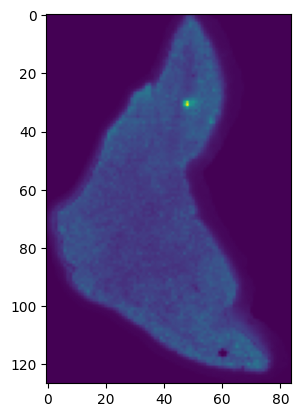

In [30]:
plt.imshow(prot_mtx)

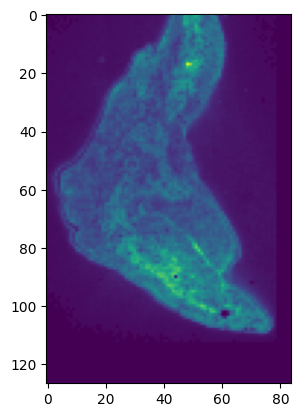

In [31]:
plt.imshow(rna_mtx)

In [32]:
# find the min dist to align the two figure
import cv2

# create an ORB detector and detect keypoints and descriptors in both images
orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(prot_mtx.astype(np.uint8), None)
kp2, des2 = orb.detectAndCompute(rna_mtx.astype(np.uint8), None)

In [33]:
# match the descriptors using a brute-force matcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)

# Sort the matches by distance (i.e. by quality)
matches = sorted(matches, key=lambda x:x.distance)

In [19]:
# Extract the matched keypoints
src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

# Find a homography that maps the first image onto the second image
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

In [38]:
# Use the homography to warp the first image onto the second image
h, w = prot_mtx.shape
warped_img1 = cv2.warpPerspective(prot_mtx, M, (w, h))

In [ ]:
# error, could due to the image size 
# Display the result 
# # cv2.imshow("Warped Image 1", warped_img1)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [56]:
# alignment the two matrix
# Using image alignment operation, we find that the each pixel in the prot_mtx 
# should be align to the rna_mtx where the coordination of y axis minus 13
def align_prot_rna_mtx(df, gene_name):
    data = df[gene_name]
    coords = np.asarray(data.index.str.split("_", expand=True))
    coordination = np.asarray([[int(coord[0]), int(coord[1])] for coord in coords])
    # delete the data with coordination[1] less than 13
    mask_ind = coordination[:, 0] >= 13
    data = data[mask_ind]
    coordination = coordination[mask_ind]
    row_ind = coordination[:, 0] - 13
    col_ind = coordination[:, 1]
    data = data.values
    coo = coo_matrix((data, (row_ind, col_ind)), shape=np.max(coordination, axis=0)+1)
    csr = coo.tocsr()
    plt.scatter(row_ind, col_ind, c=data, cmap="inferno", s=2)
    plt.title(f"{gene_name} spatial expression")
    plt.colorbar()
    plt.show()
    return csr

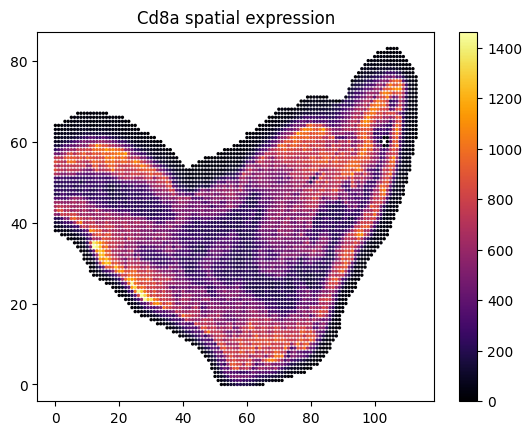

In [57]:
csr_mtx = align_prot_rna_mtx(prot_data, "Cd8a")

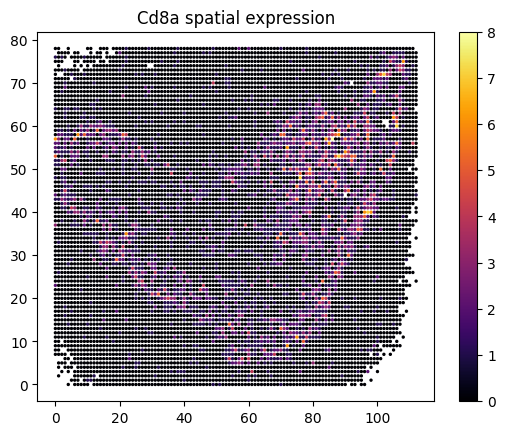

In [59]:
cd8a_rna_mtx = get_spa_gene_exp(rna_data, "Cd8a")

In [42]:
prot_data

,Cd27,Itgax,Cd8a,Cd68,Thy1,Cd3g,Cd44,Cd5,Cd4,Itgb1
Unnamed: 0,,,,,,,,,,
98_46,170,42,520,1311,150,225,156,966,724,636
27_64,17,13,58,86,34,60,41,71,77,100
87_13,284,27,707,1304,107,192,68,1142,983,479
25_53,203,168,636,2836,215,309,183,1410,1072,982
72_51,256,22,655,967,131,240,124,1263,1047,691
...,...,...,...,...,...,...,...,...,...,...
118_39,0,3,7,9,0,7,5,16,14,10
58_55,0,0,3,6,1,1,2,5,2,12
125_57,0,0,3,4,2,2,0,2,4,5


# OT result

In [35]:
# ot.dist(prot_mtx, rna_mtx)
# prot_mtx.flatten().shape, rna_mtx.flatten().shape
# define the cost matrix of the OT mapping
C = ot.dist(prot_mtx.flatten().reshape(-1, 1), rna_mtx.flatten().reshape(-1, 1))
# compute the OT mapping of the protein data to the rna data
# G0 = ot.emd(prot_mtx.flatten(), rna_mtx.flatten(), C)

In [36]:
# cost matrix
M = ot.dist(prot_mtx.flatten().reshape(-1, 1), rna_mtx.flatten().reshape(-1, 1), metric='euclidean')
# 2-wasserstein distance
M2 = pow(M, 2)

In [37]:
alpha = ot.unif(len(prot_mtx.flatten()))
beta = ot.unif(len(rna_mtx.flatten()))

In [38]:
# exact solution
P = ot.emd(alpha, beta, M, numItermax=1e5)
# Sinkhorn approximation solution
entropy_reg = 0.5 # regularization term
P_sinkhorn = ot.sinkhorn(alpha, beta, M, entropy_reg, numItermax=1000, method='sinkhorn')

RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually have the correct solution, if not try setting the maximum number of iterations a bit higher
/home/wuxinchao/.conda/envs/torch/lib/python3.10/site-packages/ot/lp/__init__.py:343: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
/home/wuxinchao/.conda/envs/torch/lib/python3.10/site-packages/ot/bregman.py:485: RuntimeWarning: divide by zero encountered in divide
  u = 1. / nx.dot(Kp, v)
/home/wuxinchao/.conda/envs/torch/lib/python3.10/site-packages/ot/bregman.py:485: RuntimeWarning: overflow encountered in divide
  u = 1. / nx.dot(Kp, v)
/home/wuxinchao/.conda/envs/torch/lib/python3.10/site-packages/ot/bregman.py:492: UserWarni

In [39]:
p = 1
# calculate the p-wasserstein distance
# pW = M * P
# direct calculate the p-wasserstein distance
# exact solution
pW = ot.emd2(alpha, beta, M, P)
# sinkhorn
pW_sinkhorn = ot.sinkhorn2(alpha, beta, M, reg=entropy_reg, numItermax=1000, method='sinkhorn')

RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually have the correct solution, if not try setting the maximum number of iterations a bit higher
/home/wuxinchao/.conda/envs/torch/lib/python3.10/site-packages/ot/lp/__init__.py:547: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


In [40]:
# (pW - pW_sinkhorn).sum()
pW
# pW_sinkhorn

209.4342866594374

In [41]:
p=2
pW = pow(ot.emd2(alpha, beta, M2), 1/p)
pW_sinkhorn = pow(ot.sinkhorn2(alpha, beta, M2, reg=entropy_reg, numItermax=1000, method='sinkhorn'), 1/p)

RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually have the correct solution, if not try setting the maximum number of iterations a bit higher


In [42]:
# get the fuzed data of the protein data and rna data
# the fuzed data is the weighted average of the protein data and rna data
# the weight is the OT mapping matrix

fuzed_mtx = ot.unif(len(prot_mtx.flatten()))
fuzed_mtx = fuzed_mtx.reshape(prot_mtx.shape)

In [54]:
# G[0].shape, G[1].shape
# a.shape, b.shape
rna_mtx.shape

(127, 84)

In [67]:
def mtx_print(rna_mtx, prot_mtx, fuzed_mtx):
    plt.figure(1, figsize=(10, 10))
    plt.subplot(221)
    plt.imshow(rna_mtx, interpolation='nearest')
    plt.title('Source data')
    plt.subplot(222)
    plt.imshow(prot_mtx, interpolation='nearest')
    plt.title('Target data')
    plt.subplot(223)
    plt.imshow(fuzed_mtx, interpolation='nearest')
    plt.title('Fuzed data')
    # plt.subplot(224)
    # plt.imshow(P, interpolation='nearest')
    # plt.title('OT matrix')
    plt.tight_layout()
    plt.show()

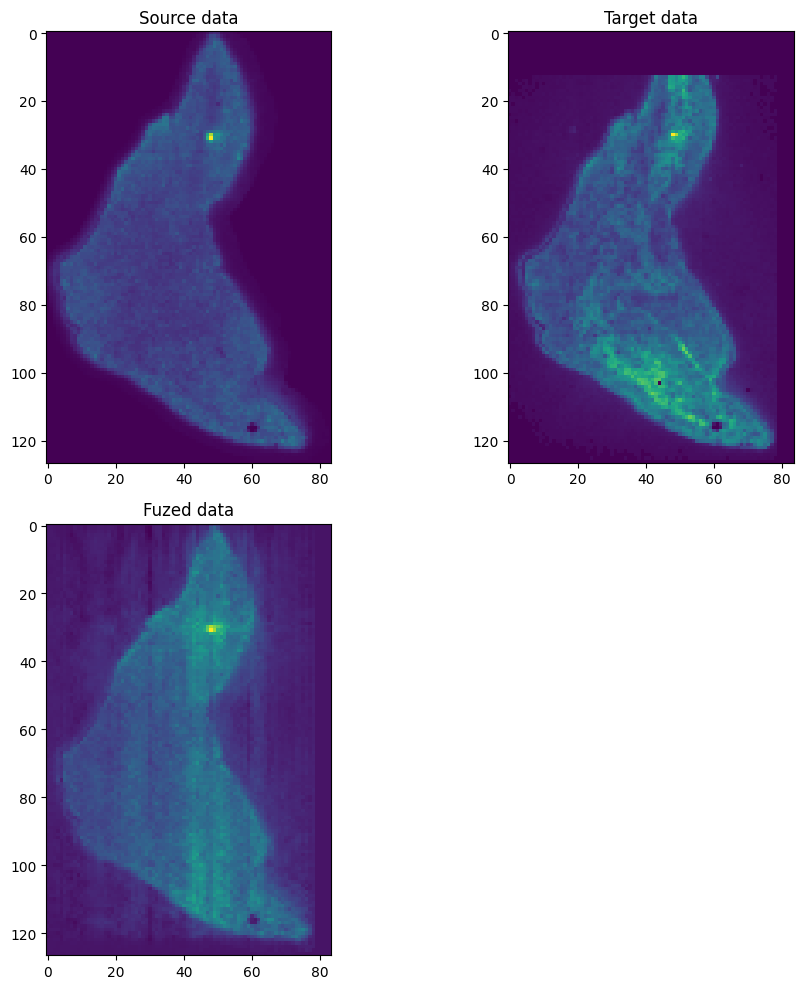

In [90]:
from ot import da

# compute optimal transport map
G = da.OT_mapping_linear(prot_mtx, rna_mtx)
# OT_mapping_linear returns the 
#  A: shape (d,d) - Linear Operator
#  b: shape (1,d) - bias
P = G[0]
# a, b = np.ones((rna_mtx.shape[0],)) / rna_mtx.shape[0], np.ones((prot_mtx.shape[0],)) / prot_mtx.shape[0]
# lambd = 1e-3
# P = da.sinkhorn(a, b, G[0], lambd, numItermax=1000)

# fuse data mtx
fuzed_mtx = prot_mtx @ P

# Display the results
mtx_print(prot_mtx, rna_mtx, fuzed_mtx)

In [62]:
# P.shape, rna_mtx.shape, prot_mtx.shape
# ((84, 84), (127, 84), (127, 84))
# compute the cost matrix of each the 
P = da.emd_laplace(0.6, 0.4, rna_mtx, prot_mtx)

((84, 84), (127, 84), (127, 84))

# Instantiate the different transport algorithms and fit them

In [ ]:
# MappingTransport with linear kernel
ot_mapping_linear = ot.da.MappingTransport(
    kernel="linear", mu=1e0, eta=1e-8, bias=True,
    max_iter=20, verbose=True)

# ot_mapping_linear.fit(Xs=prot_mtx, Xt=rna_mtx)
ot_mapping_linear.fit(Xs=prot_mtx.reshape(-1,1), Xt=rna_mtx.reshape(-1,1))

# for original source samples, transform applies barycentric mapping
transp_Xs_linear = ot_mapping_linear.transform(Xs=prot_mtx.reshape(-1,1))

# for out of source samples, transform applies the linear mapping
# transp_Xs_linear_new = ot_mapping_linear.transform(Xs=)

# MappingTransport with gaussian kernel
# ot_mapping_gaussian = ot.da.MappingTransport(
#     kernel="gaussian", eta=1e-5, mu=1e-1, bias=True, sigma=1,
#     max_iter=10, verbose=True)
# ot_mapping_gaussian.fit(Xs=prot_mtx.reshape(-1,1), Xt=rna_mtx.reshape(-1,1))

# for original source samples, transform applies barycentric mapping
# transp_Xs_gaussian = ot_mapping_gaussian.transform(Xs=prot_mtx.reshape(-1,1))

In [99]:
transp_Xs_linear.shape, transp_Xs_gaussian.shape

((10668, 1), (127, 84))

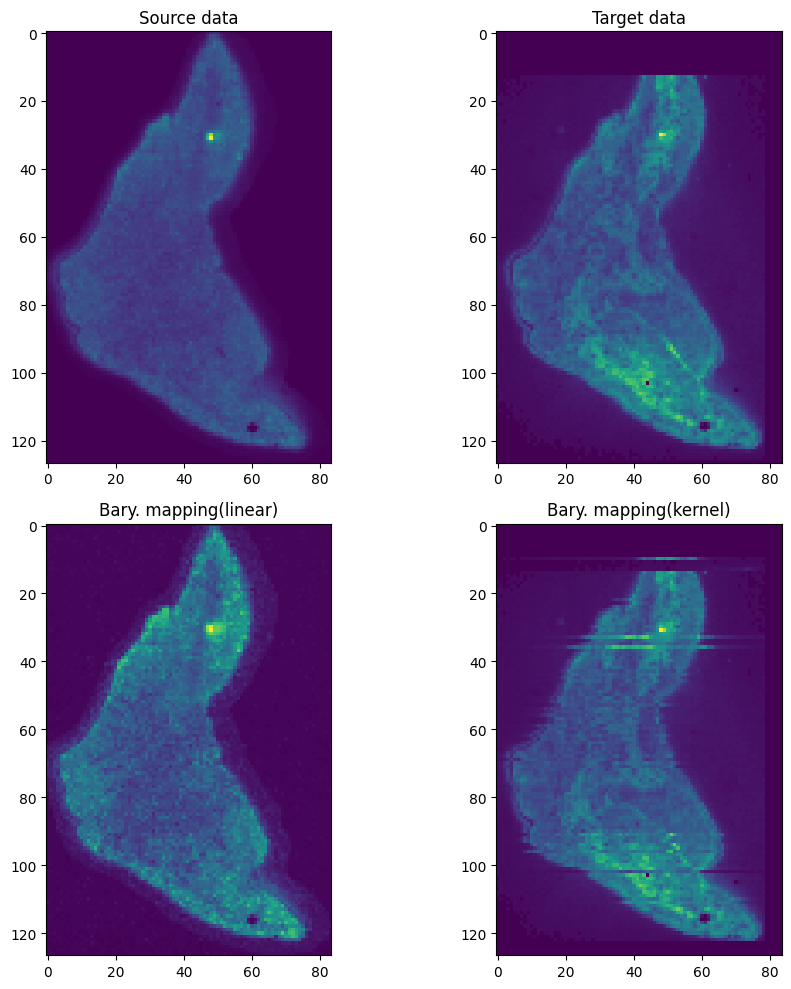

In [101]:
plt.figure(1, figsize=(10, 10))
plt.subplot(221)
plt.imshow(prot_mtx, interpolation='nearest')
plt.title('Source data')
plt.subplot(222)
plt.imshow(rna_mtx, interpolation='nearest')
plt.title('Target data')
plt.subplot(223)
plt.imshow(transp_Xs_linear.reshape(rna_mtx.shape[0], rna_mtx.shape[1]), interpolation='nearest')
plt.title('Bary. mapping(linear)')
plt.subplot(224)
plt.imshow(transp_Xs_gaussian.reshape(rna_mtx.shape[0], rna_mtx.shape[1]), interpolation='nearest')
plt.title('Bary. mapping(kernel)')
plt.tight_layout()
plt.show()

## Sampling 

In [103]:
rng = np.random.RandomState(42)
nb = 500
idx1 = rng.randint(prot_mtx.shape[0] * prot_mtx.shape[1], size=(nb,))
idx2 = rng.randint(rna_mtx.shape[0] * rna_mtx.shape[1], size=(nb,))
Xs = prot_mtx.reshape(-1, 1)[idx1, :]
Xt = rna_mtx.reshape(-1, 1)[idx2, :]

In [105]:
# EMDTransport
ot_emd = ot.da.EMDTransport()
ot_emd = ot_emd.fit(Xs=Xs, Xt=Xt)
transp_Xs_emd = ot_emd.transform(Xs=prot_mtx.reshape(-1, 1))

# SinkhornTransport
ot_sinkhorn = ot.da.SinkhornTransport(reg_e=1e-1)
ot_sinkhorn.fit(Xs=Xs, Xt=Xt)
transp_Xs_sinkhorn = ot_sinkhorn.transform(Xs=prot_mtx.reshape(-1, 1))

/home/wuxinchao/.conda/envs/torch/lib/python3.10/site-packages/ot/bregman.py:485: RuntimeWarning: divide by zero encountered in divide
  u = 1. / nx.dot(Kp, v)
/home/wuxinchao/.conda/envs/torch/lib/python3.10/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 0
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/wuxinchao/.conda/envs/torch/lib/python3.10/site-packages/ot/da.py:1125: RuntimeWarning: invalid value encountered in divide
  transp = self.coupling_ / nx.sum(


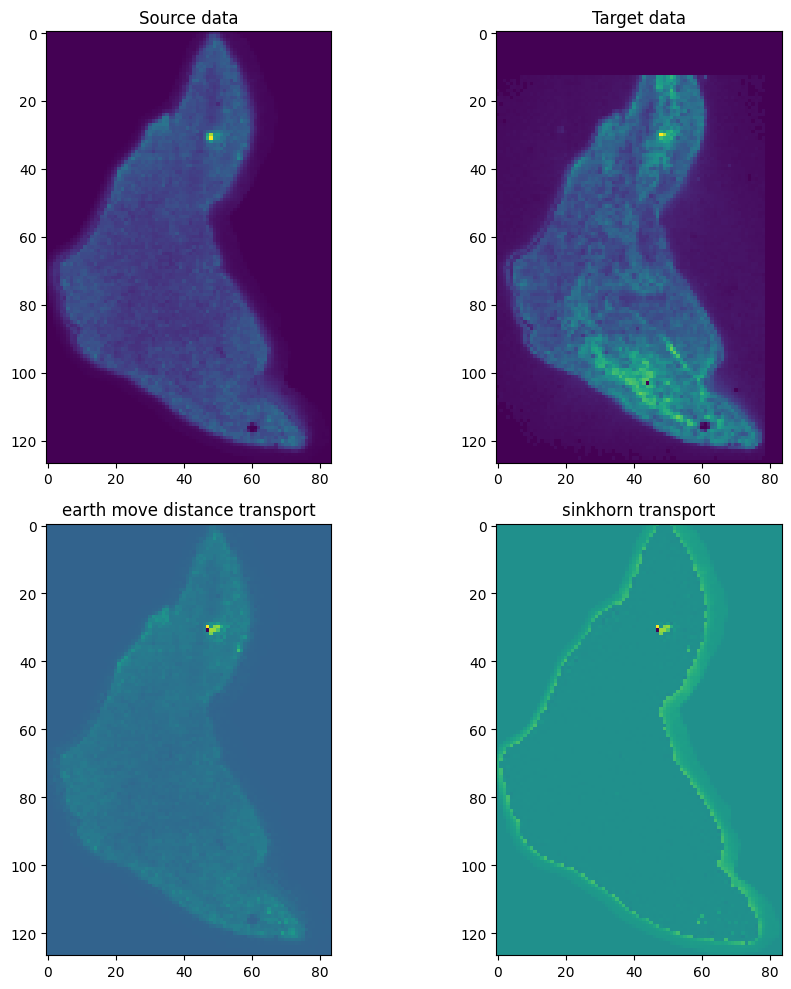

In [107]:
plt.figure(1, figsize=(10, 10))
plt.subplot(221)
plt.imshow(prot_mtx, interpolation='nearest')
plt.title('Source data')
plt.subplot(222)
plt.imshow(rna_mtx, interpolation='nearest')
plt.title('Target data')
plt.subplot(223)
plt.imshow(transp_Xs_emd.reshape(rna_mtx.shape[0], rna_mtx.shape[1]), interpolation='nearest')
plt.title('earth move distance transport')
plt.subplot(224)
plt.imshow(transp_Xs_sinkhorn.reshape(rna_mtx.shape[0], rna_mtx.shape[1]), interpolation='nearest')
plt.title('sinkhorn transport')
plt.tight_layout()
plt.show()

In [115]:
# rna_mtx.max(), prot_mtx.max(), rna_mtx.min(), prot_mtx.min()
# (293.3224881865365, 2641.1, 0.0, 0.0)
rna_mtx_norm = rna_mtx / rna_mtx.max()
prot_mtx_norm = prot_mtx / prot_mtx.max()

In [121]:
prot_mtx_norm

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# MappingTransport with linear kernel
ot_mapping_linear = ot.da.MappingTransport(
    kernel="linear", mu=1e0, eta=1e-8, bias=True,
    max_iter=20, verbose=True)

ot_mapping_linear.fit(Xs=prot_mtx_norm.reshape(-1,1), Xt=rna_mtx_norm.reshape(-1,1))

# for original source samples, transform applies barycentric mapping
transp_Xs_linear = ot_mapping_linear.transform(Xs=prot_mtx_norm.reshape(-1,1))

# MappingTransport with gaussian kernel
ot_mapping_gaussian = ot.da.MappingTransport(
    kernel="gaussian", eta=1e-5, mu=1e-1, bias=True, sigma=1,
    max_iter=10, verbose=True)

ot_mapping_gaussian.fit(Xs=prot_mtx_norm.reshape(-1,1), Xt=rna_mtx_norm.reshape(-1,1))

# for original source samples, transform applies barycentric mapping
transp_Xs_gaussian = ot_mapping_gaussian.transform(Xs=prot_mtx_norm.reshape(-1,1))

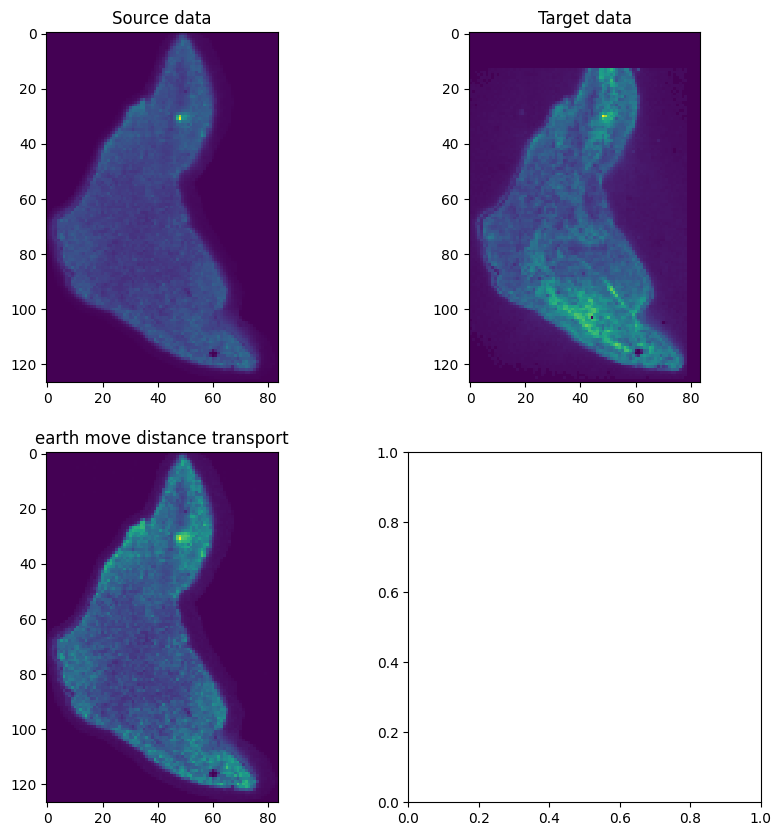

In [120]:
plt.figure(1, figsize=(10, 10))
plt.subplot(221)
plt.imshow(prot_mtx, interpolation='nearest')
plt.title('Source data')
plt.subplot(222)
plt.imshow(rna_mtx, interpolation='nearest')
plt.title('Target data')
plt.subplot(223)
plt.imshow(transp_Xs_linear.reshape(rna_mtx.shape[0], rna_mtx.shape[1]), interpolation='nearest')
plt.title('earth move distance transport')
plt.subplot(224)
# plt.imshow(transp_Xs_gaussian.reshape(rna_mtx.shape[0], rna_mtx.shape[1]), interpolation='nearest')
# plt.title('sinkhorn transport')
# plt.tight_layout()
plt.show()

In [58]:
def get_spa_gene_exp(df, gene_name):
    df = df[gene_name]
    coords = np.asarray(df.index.str.split("_", expand=True))
    coordination = np.asarray([[int(coord[0]), int(coord[1])] for coord in coords])
    row_ind = coordination[:,0]
    col_ind = coordination[:,1]
    data = df.values
    coo = coo_matrix((data, (row_ind, col_ind)), shape=np.max(coordination, axis=0)+1)
    csr = coo.tocsr()
    plt.scatter(row_ind, col_ind, c=data, cmap="inferno", s=2)
    plt.title(f"{gene_name} spatial expression")
    plt.colorbar()
    plt.show()
    return csr

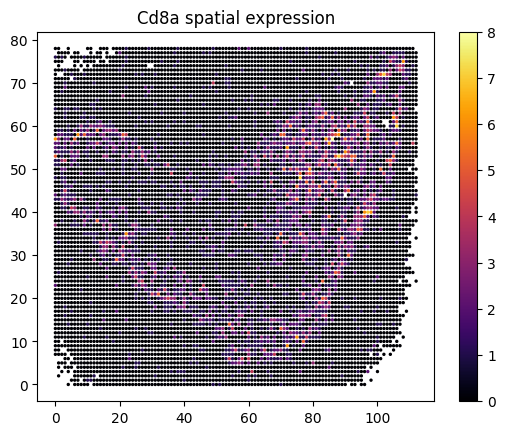

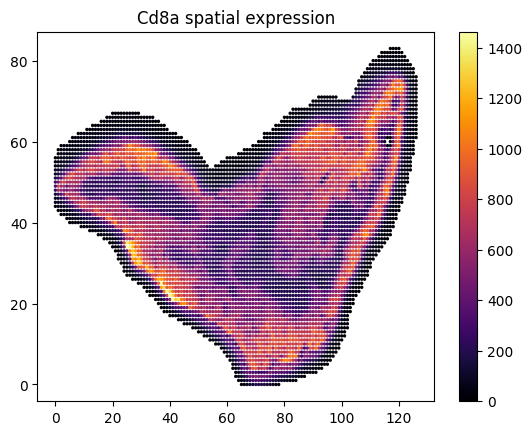

In [224]:
cd8a_rna_mtx = get_spa_gene_exp(rna_data, "Cd8a")
cd8a_prot_mtx = get_spa_gene_exp(prot_data, "Cd8a")

In [223]:
# plt.spy(csr_mtx)
# plt.imshow(csr_mtx.toarray(), cmap="inferno", interpolation="nearest")
# plt.scatter(csr_mtx.toarray()[:,0], csr_mtx.toarray()[:,1], cmap="inferno")
# csr_mtx.toarray().shape
# plt.scatter
# row_ind.max()
# np.max(coordination, axis=0) + 1
# data.shape
# col_ind.max()
# row_ind.min()

In [225]:
# normalize the rna_mtx and prot_mtx
cd8a_rna_mtx_norm = cd8a_rna_mtx / cd8a_rna_mtx.max()
cd8a_prot_mtx_norm = cd8a_prot_mtx / cd8a_prot_mtx.max()

# normalize the rna_mtx and prot_mtx through log1p
cd8a_rna_mtx_log1p = np.log1p(cd8a_rna_mtx)
cd8a_prot_mtx_log1p = np.log1p(cd8a_prot_mtx)

In [ ]:
# MappingTransport with linear kernel
ot_mapping_linear = ot.da.MappingTransport(
    kernel="linear", mu=1e0, eta=1e-8, bias=True,
    max_iter=20, verbose=True)

ot_mapping_linear.fit(Xs=cd8a_prot_mtx_norm.toarray().reshape(-1,1), 
                      Xt=cd8a_rna_mtx_norm.toarray().reshape(-1,1))

# for original source samples, transform applies barycentric mapping
transp_Xs_linear = ot_mapping_linear.transform(Xs=cd8a_prot_mtx_norm.toarray().reshape(-1,1))

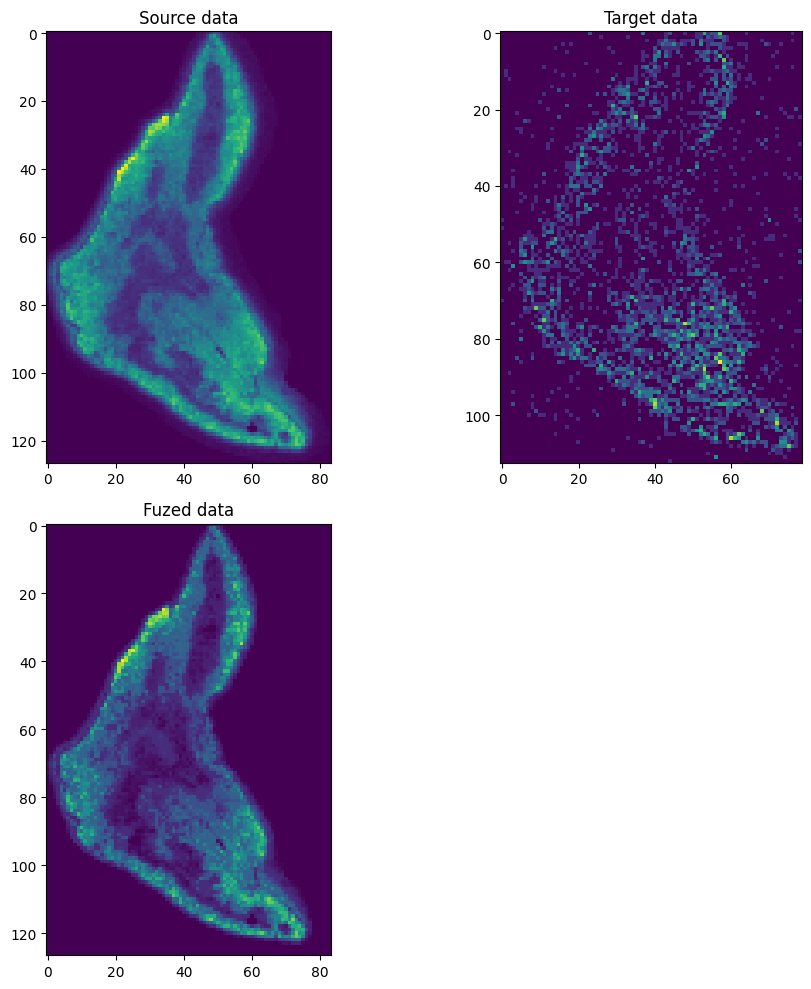

In [239]:
mtx_print(cd8a_prot_mtx_norm.toarray(), 
          cd8a_rna_mtx_norm.toarray(), 
          transp_Xs_linear.reshape(cd8a_prot_mtx.shape[0], cd8a_prot_mtx.shape[1]))

In [240]:
# MappingTransport with linear kernel
ot_mapping_linear = ot.da.MappingTransport(
    kernel="linear", mu=1e0, eta=1e-8, bias=True,
    max_iter=5, verbose=True)

ot_mapping_linear.fit(Xs=cd8a_prot_mtx_log1p.toarray().reshape(-1,1), 
                      Xt=cd8a_rna_mtx_log1p.toarray().reshape(-1,1))

# for original source samples, transform applies barycentric mapping
transp_Xs_linear = ot_mapping_linear.transform(Xs=cd8a_prot_mtx_log1p.toarray().reshape(-1,1))

RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually have the correct solution, if not try setting the maximum number of iterations a bit higher
/home/wuxinchao/.conda/envs/torch/lib/python3.10/site-packages/ot/lp/__init__.py:343: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


It.  |Loss        |Delta loss
--------------------------------
    0|5.076084e+04|0.000000e+00


RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually have the correct solution, if not try setting the maximum number of iterations a bit higher
RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually have the correct solution, if not try setting the maximum number of iterations a bit higher


    1|5.076084e+04|0.000000e+00


/home/wuxinchao/.conda/envs/torch/lib/python3.10/site-packages/ot/da.py:2207: RuntimeWarning: invalid value encountered in divide
  transp = self.coupling_ / nx.sum(self.coupling_, 1)[:, None]


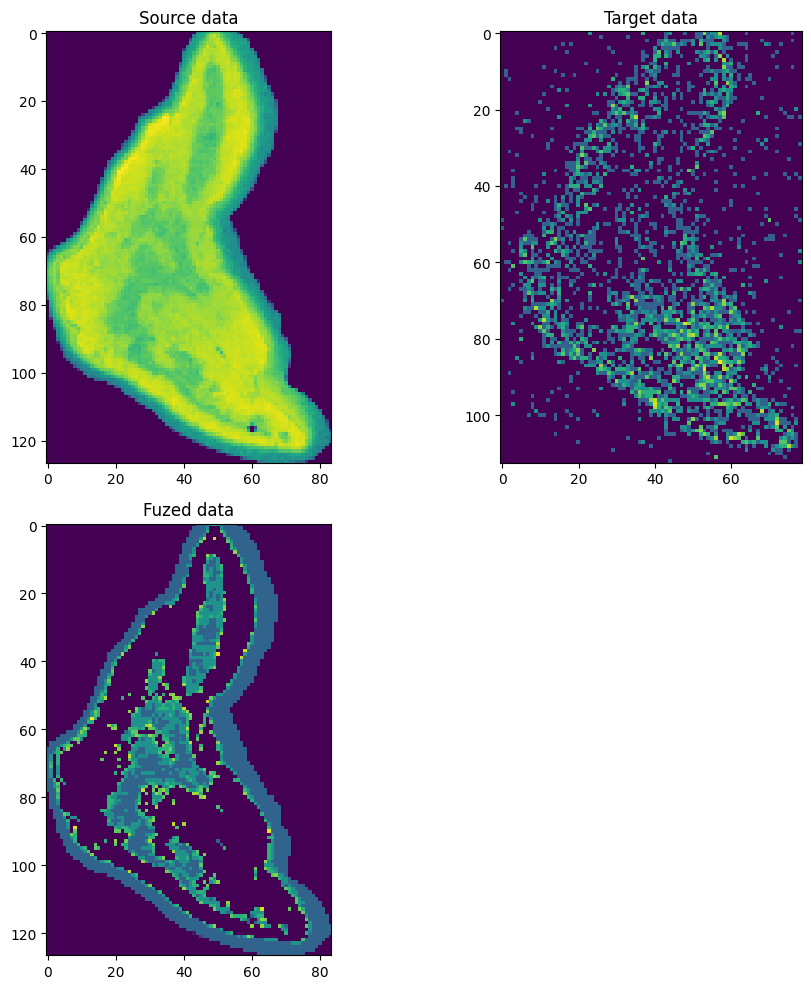

In [241]:
mtx_print(cd8a_prot_mtx_log1p.toarray(), 
          cd8a_rna_mtx_log1p.toarray(), 
          transp_Xs_linear.reshape(cd8a_prot_mtx.shape[0], cd8a_prot_mtx.shape[1]))

In [244]:
# print(cd8a_prot_mtx_log1p)
print(cd8a_rna_mtx_log1p)

  (0, 7)	0.0
  (0, 8)	0.0
  (0, 9)	0.0
  (0, 10)	0.0
  (0, 11)	0.0
  (0, 12)	0.0
  (0, 13)	0.0
  (0, 14)	0.0
  (0, 15)	0.0
  (0, 16)	0.0
  (0, 17)	0.0
  (0, 18)	0.0
  (0, 19)	0.0
  (0, 20)	0.0
  (0, 21)	0.0
  (0, 22)	0.0
  (0, 23)	1.0986122886681096
  (0, 24)	0.0
  (0, 25)	0.0
  (0, 26)	0.0
  (0, 27)	0.0
  (0, 28)	0.0
  (0, 29)	0.0
  (0, 30)	0.0
  (0, 31)	0.0
  :	:
  (112, 50)	0.0
  (112, 53)	0.0
  (112, 54)	0.0
  (112, 55)	0.0
  (112, 56)	0.0
  (112, 57)	0.0
  (112, 58)	0.0
  (112, 59)	0.0
  (112, 60)	0.0
  (112, 61)	0.0
  (112, 62)	0.0
  (112, 63)	0.0
  (112, 65)	0.0
  (112, 66)	0.0
  (112, 67)	0.0
  (112, 68)	0.0
  (112, 69)	0.0
  (112, 70)	0.0
  (112, 71)	0.0
  (112, 72)	0.0
  (112, 73)	0.0
  (112, 74)	0.0
  (112, 75)	0.0
  (112, 76)	0.0
  (112, 77)	0.0


In [ ]:
# not used
# exp(A) calculate
A = np.array([[1, 2], [3, 4]])
eA = np.zeros_like(A)
for i in range(100):
    temp = np.power(A, i) / np.math.factorial(i)
    if temp.sum() < 1e-6:
        break
    eA = eA + temp
    print(eA)
print(f"The true value is {np.exp(A)}")

np.diag(np.diag(A))